In [55]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time

import numpy as np
import skimage.transform
import skimage.measure
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import rasterio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.feature_extraction.image import extract_patches_2d

import cProfile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

def cum_sum(arr, s):
    cumsum = torch.cumsum(torch.cumsum(arr,dim=2),dim=3)
    cumsum = F.pad(cumsum,(1,0,1,0),'constant',0)
    tot = cumsum[:,:,:-s,:-s]-cumsum[:,:,s:,:-s]-cumsum[:,:,:-s,s:]+cumsum[:,:,s:,s:]
    return tot

def to_disp(arr):
    arr_c = arr.cpu().numpy()
    arr_c = np.rollaxis(np.squeeze(arr_c),0,3)
    return arr_c

#learns N x N epitome from T, K x K random patches drawn from input image x.
#Applies NIT iterations of the E-M algorithm at scale sc; T*sc^2 patches are sampled.
#e,ev = initial epitome mean and variance. The mean is initialized
#to the uniform image with some small noise, and the variance is initialized to 1
#p returns an array of probabilities of using each part of the epitome

def epitome(x,K,N,T,NIT,sc):
    #initialize parameters
    x = F.interpolate(x,scale_factor=sc)
    x = np.clip(x,0,1)
    _, numDim, SY, SX = x.shape
    TFIN = T
    T = int(np.ceil(TFIN*sc**2))
    NFIN = N
    N = int(np.ceil(sc*NFIN))
    e = torch.zeros((1,numDim,N,N)).to(device)
    ev = torch.ones((1,numDim,N,N)).to(device)
    for i in range(numDim):
        e[:,i,:,:] = x[0,i,:,:].std()*torch.randn(N,N)/100 + x[0,i,:,:].mean() #e = mean of image plus noise
    p = (torch.ones((N,N))/N**2).to(device)
    MINP = 1e-6#1e-30
    MINV = 1e-2#1e-6
    
    #allocate trace of epitome
    etr = torch.zeros((NIT+1,1,numDim,NFIN,NFIN))
    etr[0,:,:,:,:] = F.interpolate(e,[NFIN,NFIN])
    N = int(np.ceil(sc*NFIN))
    e = torch.clamp(F.interpolate(e,[N,N]),min=0,max=1)
    ev = torch.clamp(F.interpolate(ev,[N,N]),min=MINV)
    p /= torch.sum(p)
    #x = torch.clamp(x,min=0,max=1)
    T = int(np.ceil(sc**2*TFIN))
    #lP = torch.zeros((N,N),dtype=torch.float).to(device)
    sumP = torch.zeros((N,N),dtype=torch.float).to(device)
    sumPy = torch.zeros((numDim,N,N),dtype=torch.float).to(device)
    sumPy2 = torch.zeros((numDim,N,N),dtype=torch.float).to(device)
    ewrap = torch.zeros((numDim,N+K-1,N+K-1),dtype=torch.float).to(device)
    evwrap = torch.zeros((numDim,N+K-1,N+K-1),dtype=torch.float).to(device)
    SY = x.shape[2]
    SX = x.shape[3]
    ytemp = np.rollaxis(extract_patches_2d(torch.squeeze(x).permute(1,2,0),(K,K),max_patches=T),3,1)
    y = torch.from_numpy(ytemp).float().to(device)
    #perform NIT iterations of EM algorithm
    for nit in range(NIT):
        #glues together borders of e
        ewrap[:,:N,:N] = e;
        ewrap[:,N:,:] = ewrap[:,:K-1,:]
        ewrap[:,:,N:] = ewrap[:,:,:K-1]
        evwrap[:,:N,:N] = ev
        evwrap[:,N:,:] = evwrap[:,:K-1,:]
        evwrap[:,:,N:] = evwrap[:,:,:K-1]
        logevwrap = torch.log(evwrap)
        evwrapi = 1./evwrap
        # E STEP
        sumP[:,:] = 0
        sumPy[:,:,:] = 0
        sumPy2[:,:,:] = 0
        for t in range(T):
            yc = y[t,:,:,:]
            yct = torch.unsqueeze(torch.flip(yc,[1,2]),0)
            #compute posterior over patch location
            lP = torch.log(p)
            tmp1 = torch.squeeze(F.conv2d(torch.unsqueeze(evwrapi,0),yct**2))
            tmp2 = torch.squeeze(F.conv2d(torch.unsqueeze(ewrap*evwrapi,0),yct))
            tmp3 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(ewrap**2*evwrapi,0),K)),dim=0)
            tmp4 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(logevwrap,0),K)),dim=0)
            lP -= .5*(tmp4+tmp1-2*tmp2+tmp3)
            P = torch.exp(lP-torch.max(lP))+MINP
            P /= torch.sum(P)
            #update mean and variance
            tmp = P.view(1,1,N,N)
            tmp = F.pad(tmp,(K-1,K-1,K-1,K-1),'constant',0).to(device)
            tmp = torch.squeeze(cum_sum(tmp,K))
            tmp[:,:K-1] += tmp[:,N:]
            tmp[:K-1,:] += tmp[N:,:]
            sumP += tmp[:N,:N]
            tmpP = torch.unsqueeze(torch.unsqueeze(F.pad(P,(K-1,K-1,K-1,K-1),'constant',0),0),0)
            yctmp = torch.unsqueeze(yc,1)
            tmp = torch.squeeze(F.conv2d(tmpP,yctmp))
            tmp[:,:,:K-1] += tmp[:,:,N:]
            tmp[:,:K-1,:] += tmp[:,N:,:]
            sumPy += tmp[:,:N,:N]
            tmp = torch.squeeze(F.conv2d(tmpP,yctmp**2))
            tmp[:,:,:K-1] += tmp[:,:,N:]
            tmp[:,:K-1,:] += tmp[:,N:,:]
            sumPy2 += tmp[:,:N,:N]
        torch.cuda.empty_cache()
        #M STEP
        p = sumP/torch.sum(sumP)
        e[0,:,:,:] = sumPy/sumP
        ev[0,:,:,:] = sumPy2/sumP - 2*e[0,:,:,:]*sumPy/sumP+e[0,:,:,:]**2
        ev = torch.clamp(ev,min=MINV)
        etemp = F.interpolate(e,[NFIN,NFIN])
        etr[nit+1,:,:,:] = etemp
        rows,cols = 1,3
        fig=plt.figure(figsize=(cols*5,rows*5))
        fig.add_subplot(rows, cols, 1)
        plt.axis('off')
        td = to_disp(etemp[:,:3,:,:])
        plt.imshow(td)
        plt.title(str(N)+'x'+str(N)+' epitome')
        fig.add_subplot(rows, cols, 2)
        plt.axis('off')
        plt.imshow(p,cmap='hot',interpolation='nearest')
        plt.title('mixing proportions')
        fig.add_subplot(rows, cols, 3)
        plt.axis('off')
        tmp = np.sum(np.squeeze(ev.cpu().numpy()),axis=0)
        plt.imshow(tmp,cmap='hot',interpolation='nearest')
        plt.title('variances, max='+str(max(tmp.flatten())))
        plt.show()
        plt.close()   
    return e,ev,p,etr

[ 1  2  3  4  5  6 15]


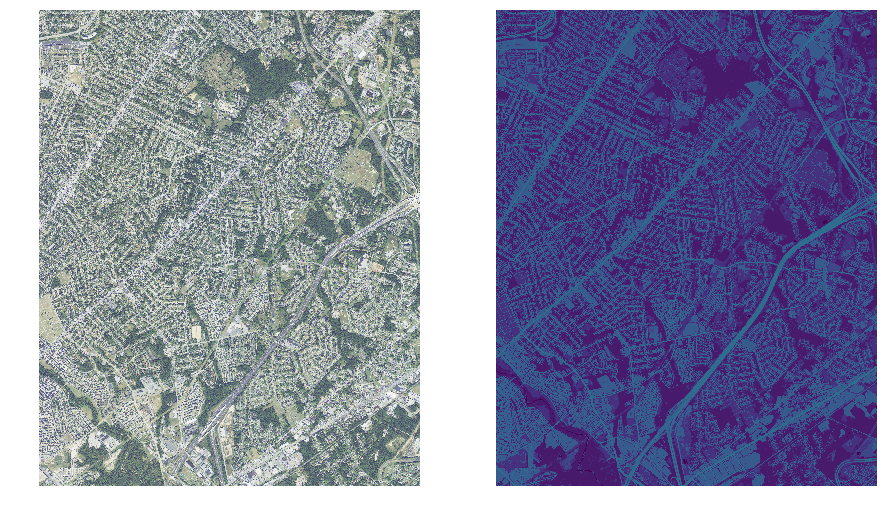

torch.Size([1, 10, 7629, 6104])
CPU times: user 7.83 s, sys: 2.68 s, total: 10.5 s
Wall time: 13.1 s


In [57]:
%%time
p = pd.read_csv("big_lc_paths.csv", header=None)
paths = p[0].tolist()
palette = np.array([[0,0,0],[0,153,51],[0,102,255],[153,102,51],[255,153,0],[255,255,0],[204,102,153]])

tile = 1
naip_tile = rasterio.open("/mnt/blobfuse/esri-naip/"+paths[tile][:-7]+".mrf",'r')
naip = naip_tile.read().astype(float)/255.
naip_tile.close()

lc_tile = rasterio.open('/mnt/blobfuse/resampled-lc/'+paths[tile],'r')
lc = np.squeeze(lc_tile.read())
lc_tile.close()
print(np.unique(lc))
#lc[lc==1]=10
#lc[lc==2]=1
#lc[lc==10]=2
#lc[lc==4]=0
#lc[lc==15]=4
fig=plt.figure(figsize=(15,10))
fig.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(np.rollaxis(naip,0,3)[:,:,:3])
fig.add_subplot(1,2,2)
plt.axis('off')
plt.imshow(lc)
plt.show()
plt.close()

trIM = np.zeros((10,naip.shape[1],naip.shape[2]),dtype=float)
trIM[:4,:,:] = naip
for i in range(6):
    trIM[4+i,:,:] = (lc==(i+1))
trIM = np.expand_dims(trIM,axis=0)
trIMtorch = torch.from_numpy(trIM).float().to(device)
tsIMtorch = trIMtorch

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


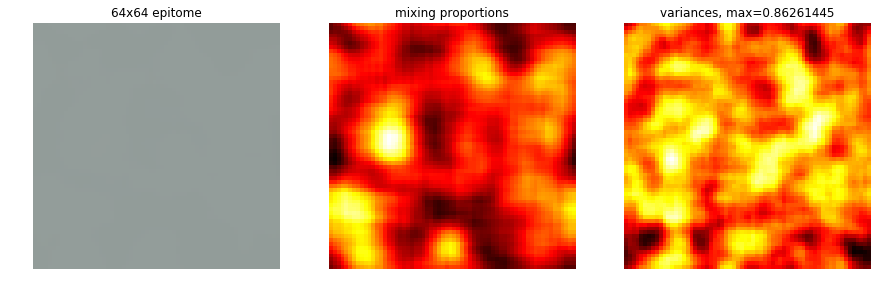

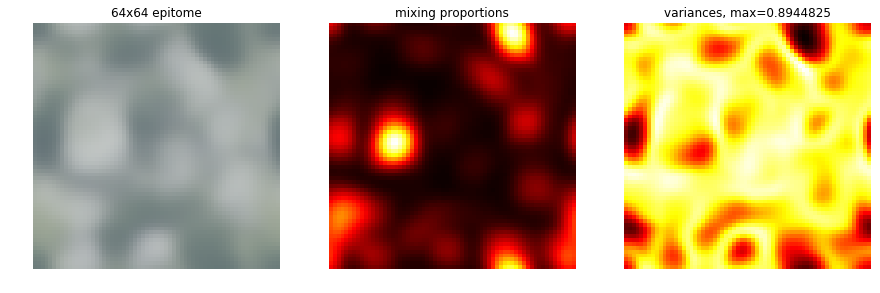

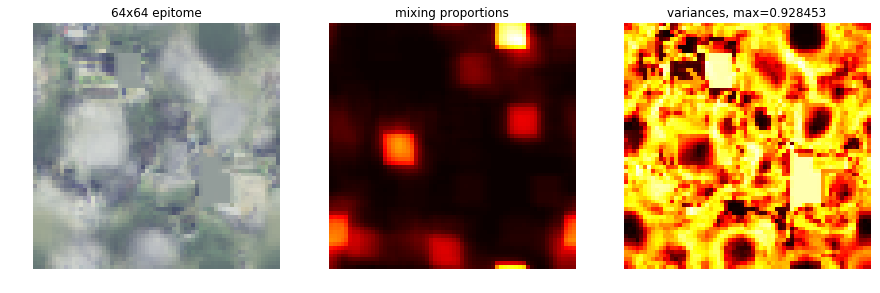

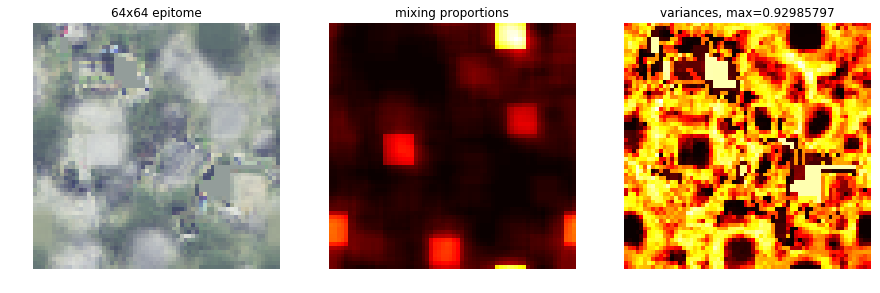

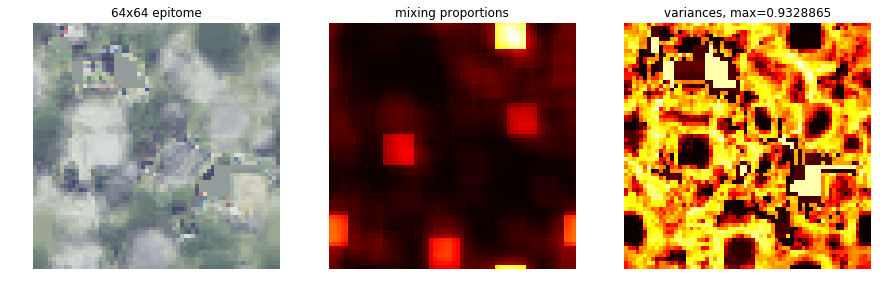

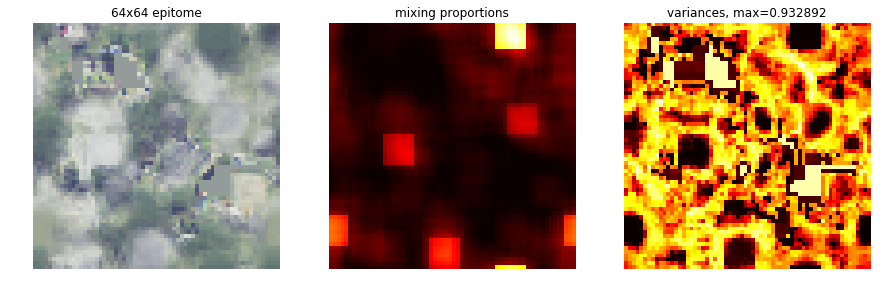

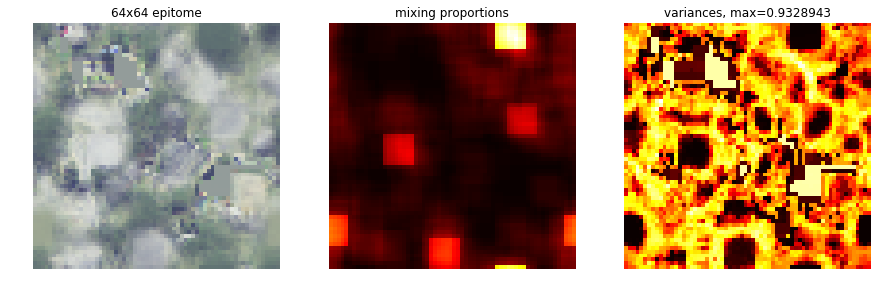

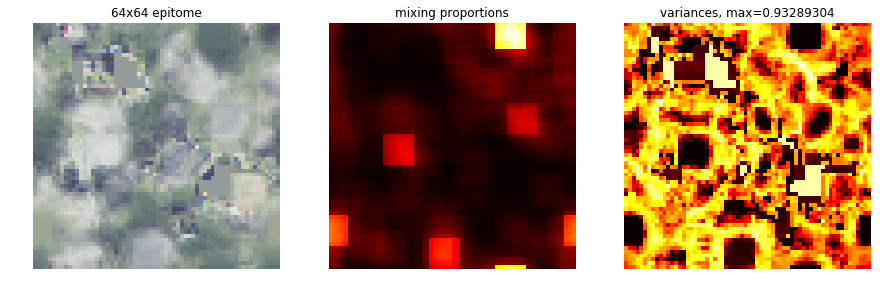

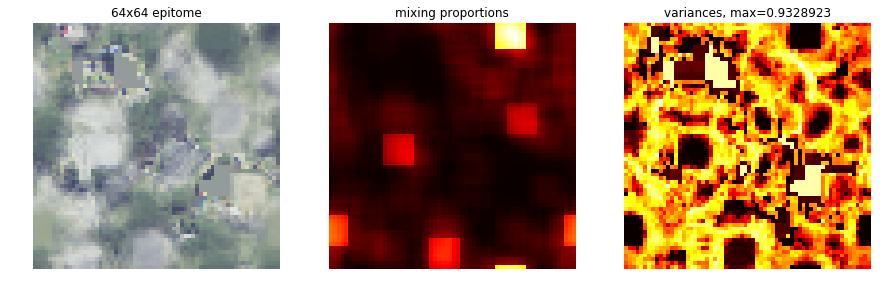

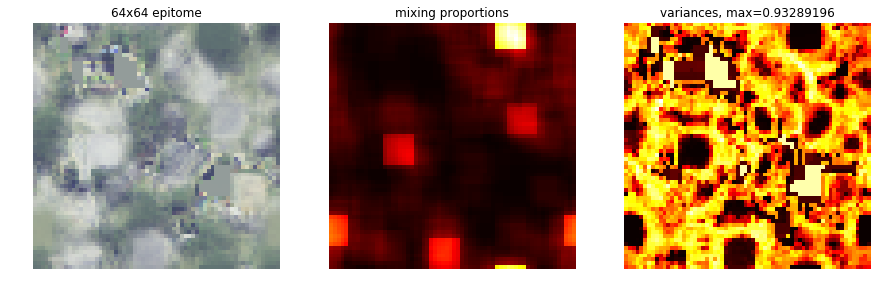

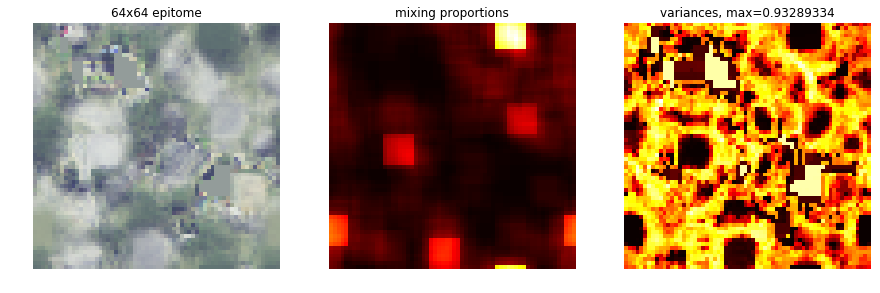

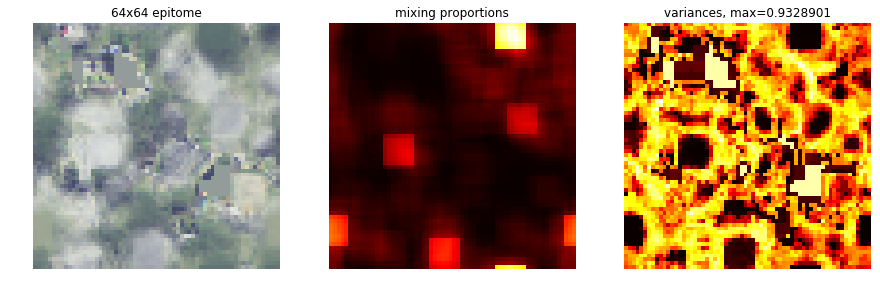

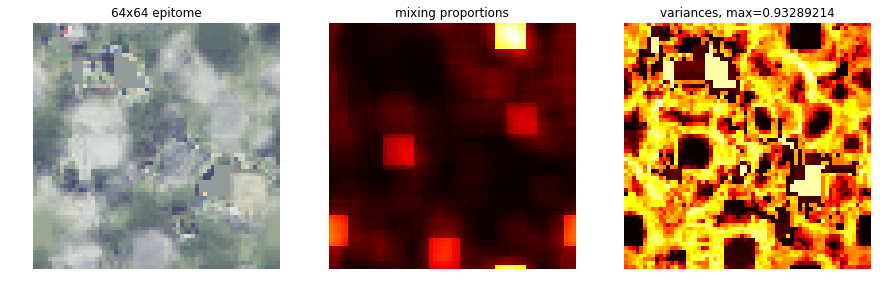

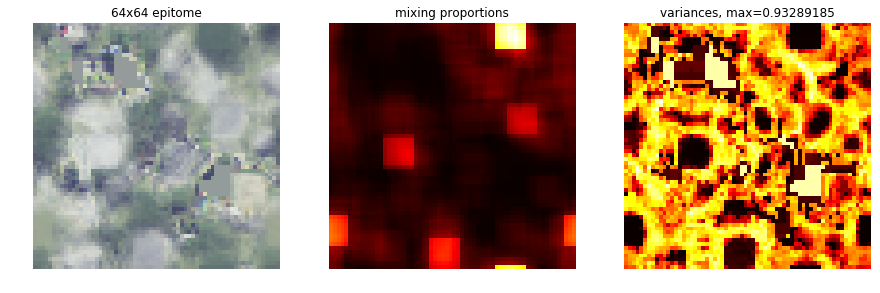

In [ ]:
%%time
#sc will be changed to a single number
#instead repeatedly call the method to create epitomes at different scales
#no longer accepts initializations of e or ev
#removed dependency on etri. removed lptr; not implemented
#e, ev, p, etr = epitome(trIMtorch,8,128,3000,30,[.5]) #scale could be [.125 .25 .5 .75]
cProfile.run('e,ev,p,etr=epitome(trIMtorch,8,128,6000,20,.5)',sort='cumtime')
torch.cuda.empty_cache()

In [48]:
#Replaces the epitome (e,ev) of an image by another epitome image (emod)
#keeping the mapping intact. The routine can be used to edit images or to
#preprocess by coloring the image accoring to the image (see the segmentation
#part of the web page for more info). K specifies the patch size to use in 
#mapping inference and SPC defines the patch spacing.

def reconstruct(x,K,e,ev,emod,SPC):
    _,NoCh1,Ny,Nx = x.shape
    NoCh2 = emod.shape[0]
    #print(NoCh1,NoCh2)
    if NoCh1 == 1:
        x = torch.stack((x,x,x),dim=0)
        print(x.shape)
    
    NoCh1,N,Ny = e.shape
    SY = x.shape[2]
    SX = x.shape[3]
    
    ewrap = torch.zeros((NoCh1,N+K-1,N+K-1)).to(device)
    evwrap = torch.zeros((NoCh1,N+K-1,N+K-1)).to(device)
    MINP = 1e-6
    MINV = 1e-2
    
    ewrap[:,:N,:N] = e
    ewrap[:,N:,:] = ewrap[:,:K-1,:]
    ewrap[:,:,N:] = ewrap[:,:,:K-1]
    evwrap[:,:N,:N] = ev
    evwrap[:,N:,:] = evwrap[:,:K-1,:]
    evwrap[:,:,N:] = evwrap[:,:,:K-1]
    logevwrap = torch.log(evwrap)
    evwrapi = 1./evwrap
    tmp3 = torch.squeeze(cum_sum(torch.unsqueeze(ewrap**2*evwrapi,0),K))
    tmp4 = torch.squeeze(cum_sum(torch.unsqueeze(logevwrap,0),K))
    #print(tmp3.shape,tmp4.shape)
    emodwrap = torch.zeros((NoCh2,N+K-1,N+K-1)).to(device)
    emodwrap[:,:N,:N] = emod
    emodwrap[:,N:,:] = emodwrap[:,:K-1,:]
    emodwrap[:,:,N:] = emodwrap[:,:,:K-1]
    
    z = torch.zeros((NoCh2,SY,SX)).to(device)
    cnt = torch.zeros((SY,SX)).to(device)
    ixt = 0
    iyt = 0
    for iy in range(0,SY-K+1,SPC):
        print('y index = '+str(iy))
        for ix in range(0,SX-K+1,SPC):
            #watch for indexing errors
            yc = x[:,:,iy:iy+K,ix:ix+K]
            yct = torch.flip(yc,[2,3])
            lP = torch.zeros(tmp4.shape).to(device)#[:,:] = 0
            #print(evwrapi.shape,ewrap.shape,evwrap.shape,yct.shape)
            tmp1 = torch.squeeze(F.conv2d(torch.unsqueeze(evwrapi,0),yct**2))
            tmp2 = torch.squeeze(F.conv2d(torch.unsqueeze(ewrap*evwrap,0),yct))
            lP += -.5*(tmp4+tmp1-2*tmp2+tmp3)
            lP = torch.sum(lP,dim=0)
            P = torch.exp(lP-torch.max(lP))+MINP
            P /= torch.sum(P)
            argmax = torch.argmax(P)
            mxpi = argmax//P.shape[0]
            mxpj = argmax - mxpi*P.shape[0]
            #watch for indexing errors
            newp = emodwrap[:,mxpi:mxpi+K,mxpj:mxpj+K]
            oldp = ewrap[:,mxpi:mxpi+K,mxpj:mxpj+K]
            z[:,iy:iy+K,ix:ix+K] += newp 
            cnt[iy:iy+K,ix:ix+K] += 1
            ixt = ix
            iyt = iy
    z = z[:,:iyt+K,:ixt+K]
    cnt = cnt[:iyt+K,:ixt+K]
    z /= cnt
    return z

In [49]:
%%time
cProfile.run('z2=reconstruct(tsIMtorch[:,:4,:300,:300],17,e[0,:4,:,:],ev[0,:4,:,:],e[0,4:,:,:],3)')
#cProfile.run('z=reconstruct(tsIMtorch[:,:4,:,:],17,e[0,:4,:,:],ev[0,:4,:,:],e[0,4:10,:,:],3)')
torch.cuda.empty_cache()

y index = 0
y index = 3
y index = 6
y index = 9
y index = 12
y index = 15
y index = 18
y index = 21
y index = 24
y index = 27
y index = 30
y index = 33
y index = 36
y index = 39
y index = 42
y index = 45
y index = 48
y index = 51
y index = 54
y index = 57
y index = 60
y index = 63
y index = 66
y index = 69
y index = 72
y index = 75
y index = 78
y index = 81
y index = 84
y index = 87
y index = 90
y index = 93
y index = 96
y index = 99
y index = 102
y index = 105
y index = 108
y index = 111
y index = 114
y index = 117
y index = 120
y index = 123
y index = 126
y index = 129
y index = 132
y index = 135
y index = 138
y index = 141
y index = 144
y index = 147
y index = 150
y index = 153
y index = 156
y index = 159
y index = 162
y index = 165
y index = 168
y index = 171
y index = 174
y index = 177
y index = 180
y index = 183
y index = 186
y index = 189
y index = 192
y index = 195
y index = 198
y index = 201
y index = 204
y index = 207
y index = 210
y index = 213
y index = 216
y index = 219
y 

In [50]:
zcpu = z2.cpu().numpy()

In [51]:
zcpu.shape

(6, 299, 299)

In [52]:
zcpu[2]

array([[1.5504208e-01, 6.0497064e-02, 4.4205820e-04, ..., 1.6777182e-01,
        1.7192534e-01, 1.7730844e-01],
       [1.8078278e-01, 1.1895452e-01, 5.1412947e-04, ..., 1.1626265e-01,
        1.2968609e-01, 1.3966848e-01],
       [1.7503774e-01, 2.2169161e-01, 1.6044168e-01, ..., 1.9782571e-04,
        1.9327951e-04, 1.9390865e-04],
       ...,
       [5.3217006e-01, 4.5011908e-01, 3.5805053e-01, ..., 6.0148716e-01,
        4.7230586e-01, 5.0891399e-01],
       [3.7957105e-01, 3.8268384e-01, 3.8784027e-01, ..., 6.3985419e-01,
        6.4223593e-01, 6.5380323e-01],
       [3.2813895e-01, 3.7431049e-01, 4.8155248e-01, ..., 8.5197401e-01,
        9.0051067e-01, 8.4545493e-01]], dtype=float32)

In [ ]:
np.savez_compressed('reconstruction2',a=zcpu)

In [53]:
zmax = np.argmax(np.reshape(zcpu,(6,-1)),axis=0)
zre = np.reshape(zmax,(zcpu.shape[1],-1))
zre.shape

(299, 299)

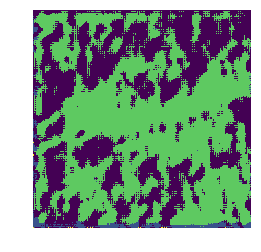

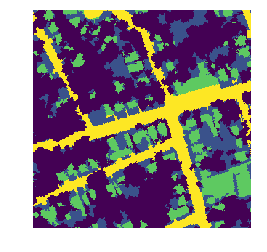

In [54]:
plt.figure()
plt.imshow(zre)
plt.axis('off')
plt.show()
plt.close()
plt.figure()
plt.imshow(lc[:300,:300])
plt.axis('off')
plt.show()
plt.close()